In [38]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [41]:
N = 100 #number of nodes
M = 40 # number of communities 
G = nx.random_partition_graph([int(N/M)]*M,1,0.0)

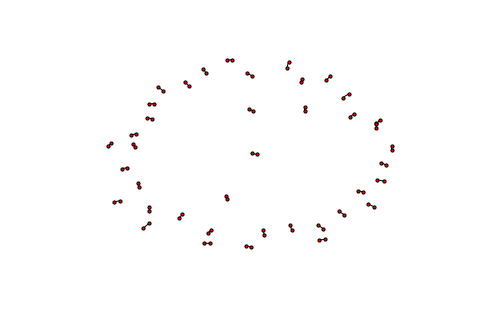

In [42]:
nx.draw(G, node_size = 10)

In [4]:
node2group = np.empty([N])
partlist = list(G.graph['partition']);
for p in range(M):
    for node in partlist[p]:
        node2group[node] = int(p)
node2group = np.asarray(node2group, dtype = int)

C = nx.Graph()
nodeset = set(range(N))
while len(nodeset) > 0:
    n  = np.random.choice(list(nodeset), 1, replace = False)[0]
    c = node2group[n]
    for neigh in G.neighbors(n):
        c_n = node2group[neigh]
        if c_n != c:
            C.add_edge(c, c_n)
    nodeset = nodeset - {n}

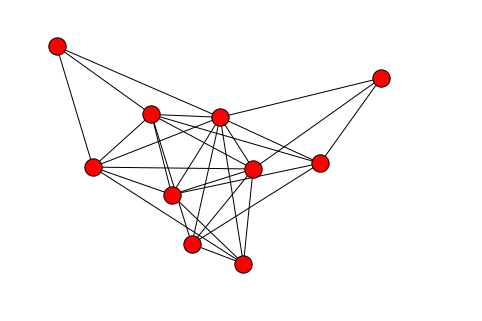

In [5]:
pos = nx.spring_layout(C)
nx.draw(C, pos=pos)

In [27]:
trialtime = 100
#infection = 0.5
trialN = 1000
steps = 50
finesse = 0.2
nswap = 10
infection  = 0.2
infection_thresh = 0.15

infectionsize = np.zeros([steps, trialtime])
neighboursize = np.zeros([steps, trialtime])
infected_neighbours = np.zeros([steps, trialtime])
infection_c_size = np.zeros([steps, trialtime])

'''
control_infectionsize = np.zeros([steps, trialtime])
control_neighboursize = np.zeros([steps, trialtime])
control_infected_neighbours = np.zeros([steps, trialtime])
'''
for trialnumber in range(trialN):
    #print(trialnumber)
    for s in range(1,steps):
        #print(s)
        Gtemp = G.copy()
        infected_nodes = set(np.random.choice(range(N), int(N*infection), replace=False))
        clean_nodes = set(range(N)) - infected_nodes
        infected_coalitions = set()
        infection  = 0.2
        infection_thresh = 0.1

        #nswaps = int(s*finesse *N/M)
        nswaps = s
        for i in range(nswap):
            [c1, c2] = np.random.choice(range(M), 2, replace=False)
            n1 = np.random.choice(list(Gtemp.graph['partition'][c1] ) ,1, replace=False)[0]
            n2 = np.random.choice(list(Gtemp.graph['partition'][c2] ) ,1, replace=False)[0]

            Gtemp.graph['partition'][c1] = Gtemp.graph['partition'][c1] | {n2}
            Gtemp.graph['partition'][c1] = Gtemp.graph['partition'][c1] - {n1}

            Gtemp.graph['partition'][c2] = Gtemp.graph['partition'][c2] | {n1}
            Gtemp.graph['partition'][c2] = Gtemp.graph['partition'][c2] - {n2}
        node2group = np.empty([N])
        partlist = list(Gtemp.graph['partition']);
        for p in range(M):
            for node in partlist[p]:
                node2group[node] = int(p)
        node2group = np.asarray(node2group, dtype = int)
        C = nx.Graph()
        nodeset = set(range(N))
        while len(nodeset) > 0:
            n  = np.random.choice(list(nodeset), 1, replace = False)[0]
            c = node2group[n]
            for neigh in Gtemp.neighbors(n):
                c_n = node2group[neigh]
                if c_n != c:
                    C.add_edge(c, c_n)
            nodeset = nodeset - {n}
        for t in range(trialtime):

            infectionsize[s][t] = infectionsize[s][t] + len(infected_nodes)/N     
            infection_c_size[s][t] = infection_c_size[s][t] + len(infected_coalitions)/M
            
            if t > 10 and len(infected_nodes)/N  <= 1/N:
                #infection_c_size[s][range(t+1, trialtime)] = 0
                #neighboursize[s][range(t+1, trialtime)] = neighboursize[s][t]
                #infected_neighbours[s][range(t+1, trialtime)] = infected_neighbours[s][t]
                break
            if t > 10 and len(infected_nodes)/N  >= 1- 1/N:
                infectionsize[s][range(t+1, trialtime)] =  infectionsize[s][range(t+1, trialtime)] + 1
                #neighboursize[s][range(t+1, trialtime)] = neighboursize[s][t]
                #infected_neighbours[s][range(t+1, trialtime)] = infected_neighbours[s][t]
                #infection_c_size[s][range(t+1, trialtime)] = 1
                break
            if len(infected_coalitions) == M:
                break
            

            if len(infected_coalitions) ==0:
                coalition = np.random.choice(range(M), 1, replace=False)[0]
            else:
                e = 0
                while e == 0:
                    nodec = np.random.choice(list(infected_coalitions), 1, replace=False)[0]
                    neighset = {c for c in C.neighbors(nodec)}
                    e = len(neighset - infected_coalitions)
                    if e > 0:
                        coalition = np.random.choice(list(neighset) ,1, replace=False)[0]
            



            #node = np.random.choice(range(N), 1, replace=False)[0]
            #coalition = partlist[node2group[node]]


            neighbors = set()
            coal =  Gtemp.graph['partition'][coalition];
            for member in coal:
                neighbors.update({n for n in G.neighbors(member)})

            neighbors =  neighbors - coal
            neighboursize[s][t] = neighboursize[s][t] + len(neighbors)
            infected_neighbours[s][t] = infected_neighbours[s][t] + len(infected_nodes.intersection(neighbors))

            if len(infected_nodes.intersection(neighbors)) >= infection_thresh*len(neighbors) :

                infected_nodes.update(coal)
                infected_coalitions.update({coalition})
                clean_nodes = set(range(N))- infected_nodes


            else :
                clean_nodes.update(coal)
                infected_nodes = set(range(N))- clean_nodes
                if coal in infected_coalitions:
                    infected_coalitions.remove(coal)

infectionsize = infectionsize/trialN
neighboursize = neighboursize/trialN
infected_neighbours = infected_neighbours/trialN
infection_c_size = infection_c_size/trialN


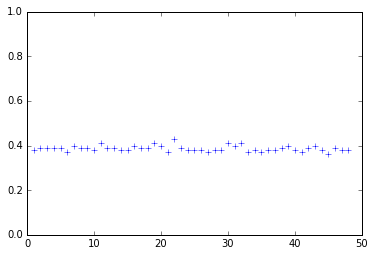

In [32]:

convergence_rate = np.zeros([steps-1])
for s in range(1,steps-1):
    
    time = np.where(infectionsize[s][range(trialtime)]>1- 1/N)[0]
    if len(time) > 0:
        convergence_rate[s] = np.min(time)
    else:
        convergence_rate[s] = trialtime
convergence_rate = convergence_rate/trialtime
plt.plot(range(steps-1), convergence_rate, 'b+')
plt.ylim(0,1)
plt.show()

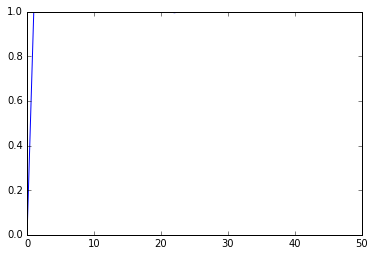

In [37]:
window = trialtime
t = range(window)
i = int(steps/2)
#plt.plot(t, infectionsize[i][t], 'k-',t, infected_neighbours[i][t]/N, 'r-', t, neighboursize[i][t]/N, 'b-')
reverse = infectionsize.T



plt.plot(np.arange(steps), reverse[trialtime-1][range(steps)], 'b-')
#plt.plot(t, coalitionsize[1][t]) 
#plt.plot(coalitionsize[i], neighboursize[i], 'b+')
plt.ylim(0, 1)
plt.show()




In [ ]:
maxneigh = np.empty([50])
for s in range(50):
    maxneigh[s] = np.max(neighboursize[s][range(50)])/N
plt.plot(range(20), maxneigh[range(20)])

In [ ]:
nx.draw(C, node_size = 10)

In [ ]:
G.graph['partition']

In [ ]:
nx.draw(G.subgraph(G.graph['partition'][1]), node_size=10)

In [ ]:
neighboursize[49][range(20)]

In [ ]:
np.min(np.where(infectionsize[2][range(trialtime)]> 1-1/N))

In [55]:
def probconnection(l_out, m):
    return 1-np.exp(-l_out*(m-1))*(2-np.exp(-l_out))**(m-2)
    #return np.exp(-l_out)*(2-np.exp(-l_out))

In [268]:
def number_of_connections(l_out, m):
    #return ((m-2)*(1-np.exp(-l_out))+1)*l_out*np.exp(-l_out)
    return ((m-2)*(1-np.exp(-l_out))+1)*l_out

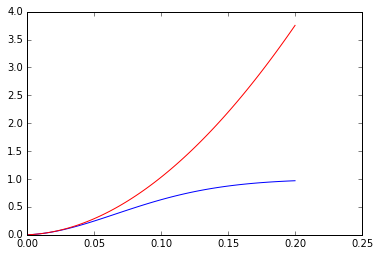

In [252]:
m = 100 #number of communities
n = 20 #number of nodes per community
lmax = n/(m-1)
plt.plot(np.arange(100)/100*lmax, probconnection(np.arange(0,100)/100*lmax,m), 'b-')
plt.plot(np.arange(100)/100*lmax, number_of_connections(np.arange(0,100)/100*lmax,m), 'r-')

In [256]:
weightrecord = np.zeros(100)
connectrecord = np.zeros(100)
trialnumber = 10
for t in range(trialnumber):
    for l in range(100):
        lam = l*lmax/99
        watertower = np.random.poisson(lam, (m,m))
        measurement = nx.complete_graph(m)
        for i in range(1,m):
            for j in range(0,i):
                if watertower[i][j] == 0:
                    measurement.remove_edge(i,j)
                else: 
                    measurement.add_edge(i,j, weight=watertower[i][j])

        adj_matrix = nx.adjacency_matrix(measurement)

        weight = np.dot(adj_matrix, adj_matrix>0) + adj_matrix
        secneigh= np.dot(adj_matrix, adj_matrix) + adj_matrix
        secneigh= secneigh>0
        connectrecord[l] =  connectrecord[l] + secneigh.sum()/m/(m-1)
        weightrecord[l] = weightrecord[l] + weight.sum()/m/(m-1) - (weight.diagonal()).sum()/m/(m-1)

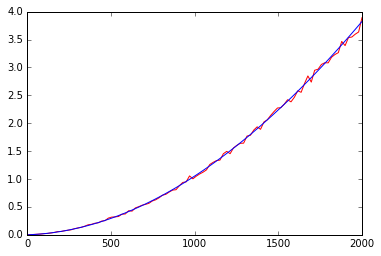

In [264]:
plt.plot(np.linspace(0,n*m,100), weightrecord/trialnumber, 'r-',np.linspace(0,n*m,100), number_of_connections(np.linspace(0,lmax,100),m), 'b-')

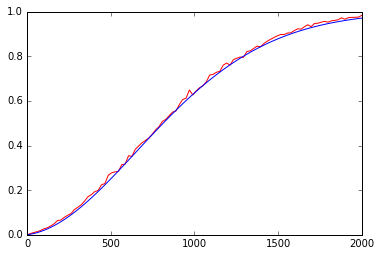

In [267]:
plt.plot(np.linspace(0,n*m,100), connectrecord/trialnumber, 'r-',np.linspace(0,n*m,100), probconnection(np.linspace(0,lmax,100),m), 'b-')

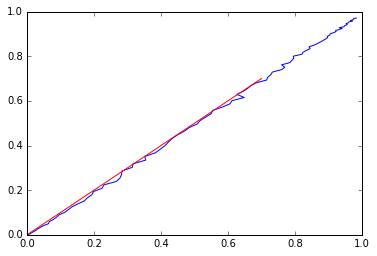

In [259]:
plt.plot(connectrecord/trialnumber, probconnection(np.linspace(0,lmax,100),m), 'b-', np.linspace(0, 0.7, 3), np.linspace(0, 0.7,3), 'r-')

In [260]:
ans = connectrecord/probconnection(np.linspace(0,lmax,100),m)/trialnumber

In [261]:
np.average(ans[range(1,100)])

1.0666382667104124

In [263]:
ans-1

array([             nan,   1.33431045e+00,   8.01643923e-01,
         4.58342295e-01,   3.42885144e-01,   3.35416646e-01,
         1.92507927e-01,   1.87858934e-01,   1.98308079e-01,
         2.87220327e-01,   1.30023252e-01,   1.44715821e-01,
         1.13453055e-01,   6.37609759e-02,   1.21275458e-01,
         9.25662253e-02,   7.26345242e-02,   9.20826010e-02,
         1.27759636e-01,   8.75774019e-02,   7.86739546e-02,
         2.40804610e-02,   7.40377038e-02,   2.59964174e-02,
         1.15897502e-01,   9.05660857e-02,   4.36423658e-02,
        -8.09096514e-03,   4.01768805e-02,  -5.18991323e-03,
         5.89978867e-02,   1.00280378e-03,   4.27452514e-02,
         3.71769263e-02,   3.16807175e-02,   1.54075801e-02,
         3.52075395e-03,   4.37030250e-03,   1.17176478e-02,
         8.16089873e-03,   2.37504579e-02,   9.85351276e-03,
         1.14658886e-02,   1.33856973e-02,  -5.34963778e-03,
         1.88298551e-02,   3.25663769e-02,   1.85386615e-02,
         5.47454717e-02,